# Model Improvement Steps

Previous notebooks, we have designed a model on fashion mnist dataset and made a simple error analysis. (Got 0.89 accuracy)
Now, I will try to improve my model by:

    -mini batching
    -batch normalization
    -hyperparameter tuning
    -learning rate decay
    -regularization


In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print(tf.__version__)

2.3.0


In [14]:
from tensorflow.keras.datasets import fashion_mnist

In [15]:
(train_images, train_labels) , (test_images, test_labels) = fashion_mnist.load_data()

In [16]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Text(0.5, 1.0, 'Ankle boot')

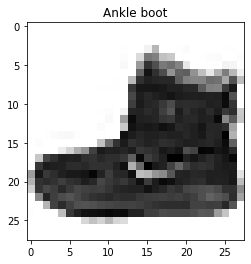

In [17]:
plt.imshow(train_images[0], cmap = plt.cm.binary)
plt.title(class_names[train_labels[0]])

In [18]:
train_labels = train_labels.reshape(60000, 1)
test_labels = test_labels.reshape(10000, 1)

In [19]:
train_images = train_images / 255
test_images = test_images / 255

In [20]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [21]:
train_num_samples = train_labels.shape[0]
test_num_samples = test_labels.shape[0]

batch_size = 64

train_steps = tf.math.ceil(train_num_samples / batch_size)
test_steps = tf.math.ceil(test_num_samples / batch_size)

train_minib = train_ds.cache().repeat().shuffle(train_num_samples).batch(batch_size)
test_minib = test_ds.cache().repeat().shuffle(test_num_samples).batch(batch_size)

In [11]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28, 28]),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "softmax")
])

model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])
    
model_info = model_1.fit(train_minib,
           epochs = 10,
           steps_per_epoch = train_steps,
           validation_data = test_minib,
           validation_steps = test_steps)


Epoch 1/10
938/938 [==============================] - 2s 2ms/step - loss: 0.5340 - accuracy: 0.8103 - val_loss: 0.4659 - val_accuracy: 0.8264
Epoch 2/10
938/938 [==============================] - 1s 2ms/step - loss: 0.3861 - accuracy: 0.8600 - val_loss: 0.4271 - val_accuracy: 0.8517
Epoch 3/10
938/938 [==============================] - 1s 1ms/step - loss: 0.3432 - accuracy: 0.8736 - val_loss: 0.3853 - val_accuracy: 0.8616s: - ETA: 0s - loss: 0.3434 - accuracy: 0.87
Epoch 4/10
938/938 [==============================] - 1s 1ms/step - loss: 0.3192 - accuracy: 0.8832 - val_loss: 0.3702 - val_accuracy: 0.8678
Epoch 5/10
938/938 [==============================] - 1s 1ms/step - loss: 0.3077 - accuracy: 0.8865 - val_loss: 0.3609 - val_accuracy: 0.8734
Epoch 6/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2874 - accuracy: 0.8935 - val_loss: 0.3622 - val_accuracy: 0.8739cy
Epoch 7/10
938/938 [==============================] - 1s 1ms/step - loss: 0.2758 - accuracy: 0.8978 - 

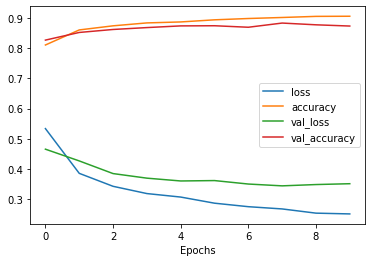

In [12]:
pd.DataFrame(model_info.history).plot()

plt.legend()
plt.xlabel("Epochs");

#### I will feed the model with mini batches and 10 epochs. Now I will try to run it with 50 epochs and assess the variance.

In [14]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28, 28]),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "softmax")
])

model_2.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])
    
model_info = model_2.fit(train_minib,
           epochs = 50,
           steps_per_epoch = train_steps,
           validation_data = test_minib,
           validation_steps = test_steps)

Epoch 1/50
938/938 [==============================] - 1s 2ms/step - loss: 0.5213 - accuracy: 0.8150 - val_loss: 0.4317 - val_accuracy: 0.8495
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 0.3773 - accuracy: 0.8621 - val_loss: 0.3860 - val_accuracy: 0.8626
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 0.3393 - accuracy: 0.8768 - val_loss: 0.3622 - val_accuracy: 0.8644
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 0.3189 - accuracy: 0.8813 - val_loss: 0.3751 - val_accuracy: 0.8628
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 0.3042 - accuracy: 0.8873 - val_loss: 0.3816 - val_accuracy: 0.8623
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 0.2853 - accuracy: 0.8940 - val_loss: 0.3423 - val_accuracy: 0.8758
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 0.2736 - accuracy: 0.8986 - val_loss: 0.3572 - val_accuracy: 0.8760
Epoch 

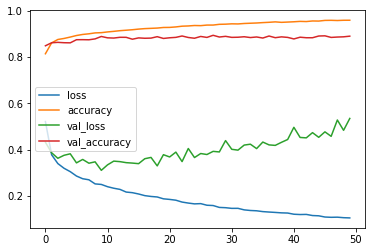

In [19]:
pd.DataFrame(model_info.history).plot()
plt.legend();

#### There is a variance problem, I will observe the model with batch normalization and then try to eliminate variance by regularization

In [21]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28, 28]),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation = "softmax")
])

model_3.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])
    
model3_info = model_3.fit(train_minib,
           epochs = 50,
           steps_per_epoch = train_steps,
           validation_data = test_minib,
           validation_steps = test_steps)

Epoch 1/50
938/938 [==============================] - 2s 2ms/step - loss: 0.5016 - accuracy: 0.8275 - val_loss: 0.4527 - val_accuracy: 0.8385
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 0.3782 - accuracy: 0.8632 - val_loss: 0.4482 - val_accuracy: 0.8410
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 0.3485 - accuracy: 0.8723 - val_loss: 0.4202 - val_accuracy: 0.8531
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 0.3207 - accuracy: 0.8822 - val_loss: 0.3926 - val_accuracy: 0.8588
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 0.3033 - accuracy: 0.8881 - val_loss: 0.3936 - val_accuracy: 0.8556
Epoch 6/50
938/938 [==============================] - 2s 2ms/step - loss: 0.2944 - accuracy: 0.8920 - val_loss: 0.3545 - val_accuracy: 0.8703
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 0.2758 - accuracy: 0.8984 - val_loss: 0.3629 - val_accuracy: 0.8703
Epoch 

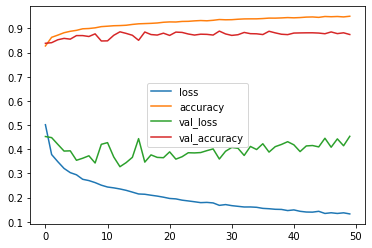

In [23]:
pd.DataFrame(model3_info.history).plot()
plt.legend()

#### There is still a variance problem and batch normalization did not facilitate the fitting process


In [39]:
model2_info_pd = pd.DataFrame(model_info.history)
model3_info_pd = pd.DataFrame(model3_info.history)

model2_info_pd["variance"] = model2_info_pd["accuracy"] - model2_info_pd["val_accuracy"]

model3_info_pd["variance"] = model3_info_pd["accuracy"] - model3_info_pd["val_accuracy"]

In [41]:
model3_info_pd

,loss,accuracy,val_loss,val_accuracy,variance
0,0.501584,0.827459,0.452722,0.838475,-0.011017
1,0.378209,0.863173,0.448225,0.840963,0.022210
2,0.348461,0.872301,0.420239,0.853105,0.019196
3,0.320747,0.882179,0.392585,0.858778,0.023402
4,0.303347,0.888093,0.393561,0.855593,0.032500
5,0.294416,0.892008,0.354465,0.870322,0.021685
6,0.275824,0.898438,0.362904,0.870322,0.028115
7,0.270471,0.899620,0.373083,0.866541,0.033080
8,0.262102,0.902402,0.343154,0.877488,0.024914
9,0.251418,0.907399,0.420518,0.848029,0.059370


#### Let's try the regularization methods to reduce the variance

In [11]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28, 28]),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation = "softmax")
])

model_4.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])
    
model4_info = model_4.fit(train_minib,
           epochs = 50,
           steps_per_epoch = train_steps,
           validation_data = test_minib,
           validation_steps = test_steps)

Epoch 1/50
938/938 [==============================] - 4s 4ms/step - loss: 0.7542 - accuracy: 0.7359 - val_loss: 0.4714 - val_accuracy: 0.8355
Epoch 2/50
938/938 [==============================] - 4s 4ms/step - loss: 0.4891 - accuracy: 0.8287 - val_loss: 0.4094 - val_accuracy: 0.8529
Epoch 3/50
938/938 [==============================] - 4s 5ms/step - loss: 0.4329 - accuracy: 0.8490 - val_loss: 0.4175 - val_accuracy: 0.8563
Epoch 4/50
938/938 [==============================] - 4s 5ms/step - loss: 0.4098 - accuracy: 0.8544 - val_loss: 0.3832 - val_accuracy: 0.8681
Epoch 5/50
938/938 [==============================] - 4s 4ms/step - loss: 0.3988 - accuracy: 0.8598 - val_loss: 0.3795 - val_accuracy: 0.8635
Epoch 6/50
938/938 [==============================] - 4s 5ms/step - loss: 0.3738 - accuracy: 0.8678 - val_loss: 0.3820 - val_accuracy: 0.8607
Epoch 7/50
938/938 [==============================] - 4s 5ms/step - loss: 0.3691 - accuracy: 0.8700 - val_loss: 0.3802 - val_accuracy: 0.8665
Epoch 

In [12]:
model4_info_pd = pd.DataFrame(model4_info.history)

model4_info_pd["variance"] = model4_info_pd["accuracy"] - model4_info_pd["val_accuracy"]

In [55]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28, 28]),
    tf.keras.layers.Dense(100,
                         activation = "relu",
                         kernel_regularizer = tf.keras.regularizers.l1(0.002) ),
    tf.keras.layers.Dense(64, 
                         activation = "relu",
                         kernel_regularizer = tf.keras.regularizers.l1(0.002)),
    tf.keras.layers.Dense(32, 
                         activation = "relu",
                         kernel_regularizer = tf.keras.regularizers.l1(0.002)),
    tf.keras.layers.Dense(10, activation = "softmax")
])

model_5.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])
    
model5_info = model_5.fit(train_minib,
           epochs = 50,
           steps_per_epoch = train_steps,
           validation_data = test_minib,
           validation_steps = test_steps)

Epoch 1/50
938/938 [==============================] - 2s 2ms/step - loss: 1.9645 - accuracy: 0.7576 - val_loss: 1.2152 - val_accuracy: 0.7964
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 1.0947 - accuracy: 0.7971 - val_loss: 1.0048 - val_accuracy: 0.7965 1.1499 - ac - ETA: 0s - loss: 1.1275 - accuracy: 0. - ETA: 0s - loss: 1.1167 - accura
Epoch 3/50
938/938 [==============================] - 1s 2ms/step - loss: 0.9505 - accuracy: 0.8063 - val_loss: 0.9122 - val_accuracy: 0.8098 - loss: 0.9765 - accuracy - ETA: 0s - loss: 0.9713 -  - ETA: 0s - loss: 0.9528 - accuracy: 
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 0.8813 - accuracy: 0.8138 - val_loss: 0.8870 - val_accuracy: 0.7975 loss: 0.9032 - accuracy:  - ETA: 0s - loss: 0.9046 - accuracy: 0. - ETA: 0s - los - ETA: 0s - loss: 0.8822 - accuracy: 0.81
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 0.8468 - accuracy: 0.8178 - val_loss: 0.8654 - val_accur

938/938 [==============================] - 1s 1ms/step - loss: 0.6643 - accuracy: 0.8328 - val_loss: 0.7101 - val_accuracy: 0.8166s: 0.6596 - accuracy:  - ETA: 0s - loss: 0.6616 - accuracy: 0.83 - ETA: 0s - loss: 0.6596 - accuracy: 0. - ETA: 0s - loss: 0.6578 - accura - ETA: 0s - loss: 0.6628 - accuracy: 0.
Epoch 43/50
938/938 [==============================] - 1s 2ms/step - loss: 0.6518 - accuracy: 0.8385 - val_loss: 0.6818 - val_accuracy: 0.8240: 1s - loss: 0.6592 -  - ETA: 0s - loss: 0.6558 - accura - ETA: 0s - loss: 0.6538 - accuracy - ETA: 0s - loss: 0.6523 - accuracy: 0.
Epoch 44/50
938/938 [==============================] - 1s 2ms/step - loss: 0.6581 - accuracy: 0.8364 - val_loss: 0.6844 - val_accuracy: 0.8213 - loss: 0.6575 - accu - ETA: 0s - loss: 0.6575 - accura - ETA: 0s - loss: 0.6576 - accuracy: 0.83
Epoch 45/50
938/938 [==============================] - 1s 1ms/step - loss: 0.6591 - accuracy: 0.8362 - val_loss: 0.6805 - val_accuracy: 0.8294 - loss: 0.6628 - accuracy: 0. - 

In [56]:
model5_info_pd = pd.DataFrame(model5_info.history)

model5_info_pd["variance"] = model5_info_pd["accuracy"] - model5_info_pd["val_accuracy"]

In [71]:
values = list(model2_info_pd.columns)

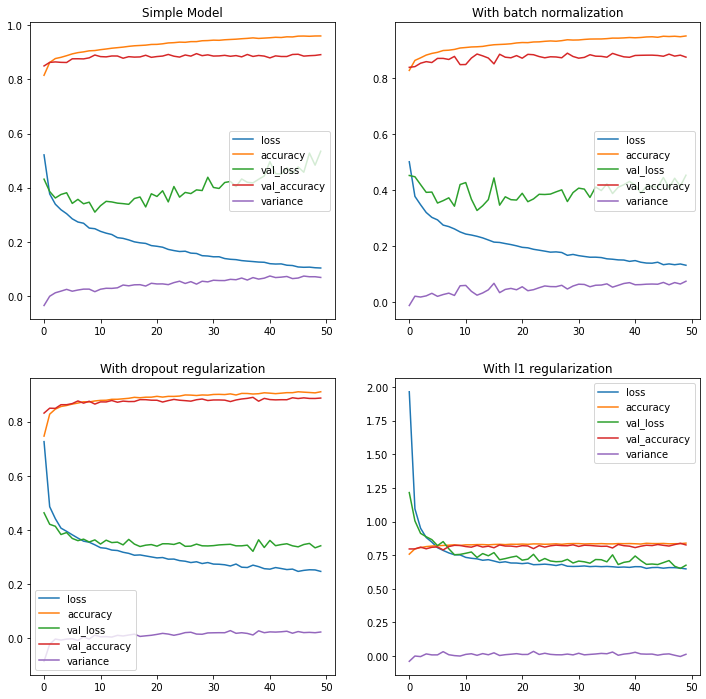

In [76]:
plt.figure(figsize = (12, 12))

plt.subplot(2, 2, 1)
plt.plot(model2_info_pd)
plt.legend(values)
plt.title("Simple Model")

plt.subplot(2, 2, 2)
plt.plot(model3_info_pd)
plt.legend(values)
plt.title("With batch normalization")

plt.subplot(2, 2, 3)
plt.plot(model4_info_pd)
plt.legend(values)
plt.title("With dropout regularization")

plt.subplot(2, 2, 4)
plt.plot(model5_info_pd)
plt.legend(values)
plt.title("With l1 regularization");

#### We can actually say that regularization methods reduce the variance but meanwhile they increase the bias.

In [92]:
test_acc_2  = model2_info_pd["val_accuracy"]
test_acc_3 = model3_info_pd["val_accuracy"]
test_acc_4 = model4_info_pd["val_accuracy"]
test_acc_5 = model5_info_pd["val_accuracy"]

test_acc_df = pd.DataFrame(test_acc_2)
test_acc_df["model2"] = test_acc_2 
test_acc_df["model3"] = test_acc_3
test_acc_df["model4"] = test_acc_4
test_acc_df["model5"] = test_acc_5

test_acc_df.drop(["val_accuracy"], axis = 1, inplace = True)

In [98]:
var_2  = model2_info_pd["variance"]
var_3 = model3_info_pd["variance"]
var_4 = model4_info_pd["variance"]
var_5 = model5_info_pd["variance"]

var_df = pd.DataFrame(var_2)
var_df["model2"] = var_2 
var_df["model3"] = var_3
var_df["model4"] = var_4
var_df["model5"] = var_5

var_df.drop(["variance"], axis = 1, inplace = True)

Text(0.5, 1.0, 'variance')

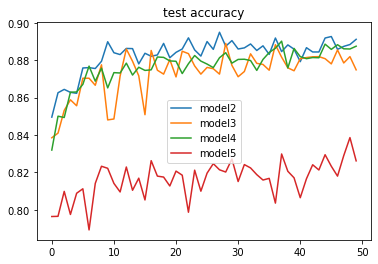

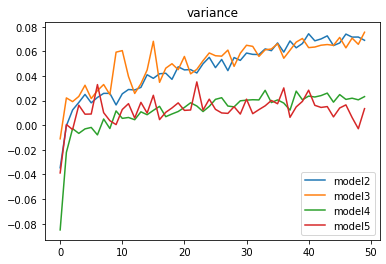

In [100]:
test_acc_df.plot()
plt.title("test accuracy")

var_df.plot()
plt.title("variance")

#### Model 4 is the best option to tune hyperparameters. ( low variance and bias ) 

#### Before the hyperparameter tuning, I want to run the model with learning_rate_decay

In [14]:
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (1 / (1 + (0.2 * epoch))) * 0.01)

model_6 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28, 28]),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation = "softmax")
])

model_6.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])
    
model6_info = model_6.fit(train_minib,
           epochs = 50,
           steps_per_epoch = train_steps,
           validation_data = test_minib,
           validation_steps = test_steps,
           callbacks = [learning_rate_callback])

Epoch 1/50
938/938 [==============================] - 4s 5ms/step - loss: 0.7669 - accuracy: 0.7161 - val_loss: 0.5539 - val_accuracy: 0.8021
Epoch 2/50
938/938 [==============================] - 3s 4ms/step - loss: 0.6207 - accuracy: 0.7788 - val_loss: 0.5377 - val_accuracy: 0.8101
Epoch 3/50
938/938 [==============================] - 4s 5ms/step - loss: 0.5760 - accuracy: 0.7966 - val_loss: 0.5339 - val_accuracy: 0.8178
Epoch 4/50
938/938 [==============================] - 4s 4ms/step - loss: 0.5485 - accuracy: 0.8060 - val_loss: 0.4724 - val_accuracy: 0.8372
Epoch 5/50
938/938 [==============================] - 4s 4ms/step - loss: 0.5346 - accuracy: 0.8125 - val_loss: 0.4541 - val_accuracy: 0.8433
Epoch 6/50
938/938 [==============================] - 4s 4ms/step - loss: 0.5099 - accuracy: 0.8185 - val_loss: 0.4481 - val_accuracy: 0.8390
Epoch 7/50
938/938 [==============================] - 4s 4ms/step - loss: 0.5022 - accuracy: 0.8222 - val_loss: 0.4408 - val_accuracy: 0.8428
Epoch 

In [15]:
model6_info_pd = pd.DataFrame(model6_info.history)

model6_info_pd["variance"] = model6_info_pd["accuracy"] - model6_info_pd["val_accuracy"]

<AxesSubplot:>

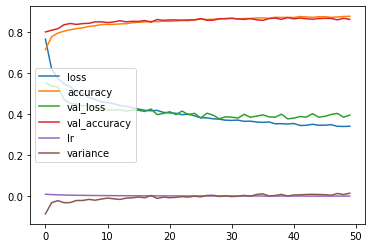

In [16]:
model6_info_pd.plot()

<AxesSubplot:>

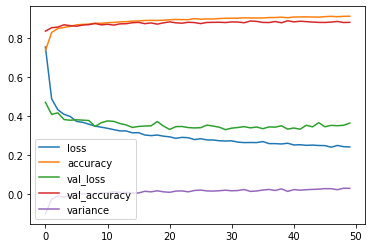

In [13]:
model4_info_pd.plot()

In [8]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def createmodel(layers, dropout_rates, learning_rates):
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape = [28, 28]))
    
    for units in layers:
        
        model.add(tf.keras.layers.Dense(units, activation = "relu"))
        model.add(tf.keras.layers.Dropout(dropout_rates))
        
    model.add(tf.keras.layers.Dense(10, activation = "softmax"))
    
    
    model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer = tf.keras.optimizers.Adam(learning_rates),
                 metrics = ["accuracy"])

    return model

In [31]:
model = KerasClassifier(build_fn = createmodel, verbose = 1, epochs = 10)

In [32]:
layers_params  = ( (100,50,20), (50, 50), (100, 100, 100))
dropout_rates_params = (0.1, 0.2)
learning_rates_params = (0.001, 0.002, 0.005)

param_grid = dict(layers = layers_params,
                 dropout_rates = dropout_rates_params,
                 learning_rates = learning_rates_params)

In [5]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [34]:
grid = GridSearchCV(estimator = model,
                   param_grid = param_grid,
                   n_jobs = -1,
                   verbose = 2,
                   cv = 3)

In [35]:
grid.fit(train_images, train_labels)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6403 - accuracy: 0.7762: 2s - loss: 1.3532  - ETA: 1s - los
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4458 - accuracy: 0.8403
Epoch 3/10
1875/1875 [==============================] - 2s 831us/step - loss: 0.4061 - accuracy: 0.8532
Epoch 4/10
1875/1875 [==============================] - 1s 727us/step - loss: 0.3806 - accuracy: 0.8633
Epoch 5/10
1875/1875 [==============================] - 1s 734us/step - loss: 0.3623 - accuracy: 0.8694
Epoch 6/10
1875/1875 [==============================] - 1s 698us/step - loss: 0.3470 - accuracy: 0.8744
Epoch 7/10
1875/1875 [==============================] - 1s 705us/step - loss: 0.3363 - accuracy: 0.8773
Epoch 8/10
1875/1875 [==============================] - 2s 996us/step - loss: 0.3275 - accuracy: 0.8806
Epoch 9/10
1875/1875 [==============================] - 1s 799us/step - los

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002518F2822B0>,
             n_jobs=-1,
             param_grid={'dropout_rates': (0.1, 0.2),
                         'layers': ((100, 50, 20), (50, 50), (100, 100, 100)),
                         'learning_rates': (0.001, 0.002, 0.005)},
             verbose=2)

In [36]:
grid.best_params_

{'dropout_rates': 0.1, 'layers': (100, 50, 20), 'learning_rates': 0.001}

In [37]:
grid.best_score_

0.8800666729609171

In [39]:
cv_df = pd.DataFrame(grid.cv_results_)

In [40]:
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout_rates,param_layers,param_learning_rates,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,80.830071,5.783206,4.301488,1.252778,0.1,"(100, 50, 20)",0.001,"{'dropout_rates': 0.1, 'layers': (100, 50, 20)...",0.87875,0.88245,0.87900,0.880067,0.001688,1
1,78.533546,6.370929,7.408177,2.830907,0.1,"(100, 50, 20)",0.002,"{'dropout_rates': 0.1, 'layers': (100, 50, 20)...",0.87395,0.87930,0.87515,0.876133,0.002292,5
2,71.074030,4.695739,4.876624,1.235452,0.1,"(100, 50, 20)",0.005,"{'dropout_rates': 0.1, 'layers': (100, 50, 20)...",0.86270,0.85415,0.86385,0.860233,0.004327,13
3,61.930878,3.036554,5.474042,1.005238,0.1,"(50, 50)",0.001,"{'dropout_rates': 0.1, 'layers': (50, 50), 'le...",0.87875,0.88255,0.87810,0.879800,0.001963,3
4,62.857082,1.852378,3.993654,0.310228,0.1,"(50, 50)",0.002,"{'dropout_rates': 0.1, 'layers': (50, 50), 'le...",0.87215,0.87185,0.87545,0.873150,0.001631,8
5,64.760302,4.209372,9.360305,4.634752,0.1,"(50, 50)",0.005,"{'dropout_rates': 0.1, 'layers': (50, 50), 'le...",0.84470,0.86225,0.85620,0.854383,0.007279,15
6,88.917789,1.927767,6.869148,1.000330,0.1,"(100, 100, 100)",0.001,"{'dropout_rates': 0.1, 'layers': (100, 100, 10...",0.87545,0.88430,0.88035,0.880033,0.003620,2
7,86.691287,1.037127,10.427088,7.412339,0.1,"(100, 100, 100)",0.002,"{'dropout_rates': 0.1, 'layers': (100, 100, 10...",0.87675,0.88300,0.87365,0.877800,0.003889,4
8,95.071951,1.996133,8.303171,1.350716,0.1,"(100, 100, 100)",0.005,"{'dropout_rates': 0.1, 'layers': (100, 100, 10...",0.83735,0.85875,0.86550,0.853867,0.012000,16
9,95.221227,1.430003,5.678803,1.731231,0.2,"(100, 50, 20)",0.001,"{'dropout_rates': 0.2, 'layers': (100, 50, 20)...",0.87410,0.87525,0.87565,0.875000,0.000657,6


In [42]:
cv_df.sort_values(["rank_test_score"], inplace = True)

In [43]:
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout_rates,param_layers,param_learning_rates,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,80.830071,5.783206,4.301488,1.252778,0.1,"(100, 50, 20)",0.001,"{'dropout_rates': 0.1, 'layers': (100, 50, 20)...",0.87875,0.88245,0.87900,0.880067,0.001688,1
6,88.917789,1.927767,6.869148,1.000330,0.1,"(100, 100, 100)",0.001,"{'dropout_rates': 0.1, 'layers': (100, 100, 10...",0.87545,0.88430,0.88035,0.880033,0.003620,2
3,61.930878,3.036554,5.474042,1.005238,0.1,"(50, 50)",0.001,"{'dropout_rates': 0.1, 'layers': (50, 50), 'le...",0.87875,0.88255,0.87810,0.879800,0.001963,3
7,86.691287,1.037127,10.427088,7.412339,0.1,"(100, 100, 100)",0.002,"{'dropout_rates': 0.1, 'layers': (100, 100, 10...",0.87675,0.88300,0.87365,0.877800,0.003889,4
1,78.533546,6.370929,7.408177,2.830907,0.1,"(100, 50, 20)",0.002,"{'dropout_rates': 0.1, 'layers': (100, 50, 20)...",0.87395,0.87930,0.87515,0.876133,0.002292,5
9,95.221227,1.430003,5.678803,1.731231,0.2,"(100, 50, 20)",0.001,"{'dropout_rates': 0.2, 'layers': (100, 50, 20)...",0.87410,0.87525,0.87565,0.875000,0.000657,6
15,74.953581,1.752929,6.358318,4.223258,0.2,"(100, 100, 100)",0.001,"{'dropout_rates': 0.2, 'layers': (100, 100, 10...",0.87135,0.87640,0.87545,0.874400,0.002191,7
4,62.857082,1.852378,3.993654,0.310228,0.1,"(50, 50)",0.002,"{'dropout_rates': 0.1, 'layers': (50, 50), 'le...",0.87215,0.87185,0.87545,0.873150,0.001631,8
16,73.724269,2.124253,4.071795,0.603708,0.2,"(100, 100, 100)",0.002,"{'dropout_rates': 0.2, 'layers': (100, 100, 10...",0.86235,0.87340,0.87505,0.870267,0.005638,9
10,88.657718,10.105912,8.555450,1.373105,0.2,"(100, 50, 20)",0.002,"{'dropout_rates': 0.2, 'layers': (100, 50, 20)...",0.86735,0.87480,0.86595,0.869367,0.003884,10


In [44]:
### dropout_rate = 0.1 and learning_rate = 0.001 way more dominant. We will tune our hyperparameters over them.

In [46]:
### Let's try RandomizedSearchCV and try to tune LearningRate

In [9]:
def createmodel2(learning_rates):
    
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = [28, 28]),
        tf.keras.layers.Dense(100, activation = "relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(50, activation = "relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(20, activation = "relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(10, activation = "softmax")
    ])
    
    model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer = tf.keras.optimizers.Adam(learning_rates),
                  metrics = ["accuracy"]
                 )
    
    return model

In [10]:
model = KerasClassifier(build_fn = createmodel2, verbose = 1)

In [28]:
from scipy.stats import uniform

In [47]:
learning_rates_arr = 10 ** (- uniform.rvs(1, 4, 100))


In [48]:
distributions = dict(learning_rates = learning_rates_arr)

random_cv = RandomizedSearchCV(estimator = model,
                              param_distributions = distributions,
                              cv= 3)

In [49]:
random_cv.fit(train_images, train_labels)

625/625 [==============================] - 0s 517us/step - loss: 1.3574 - accuracy: 0.6069


RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002901E747100>, as the constructor either does not set or modifies parameter learning_rates

In [51]:
array_of_tuples = map(tuple, learning_rates_arr.reshape(100,1))
tuple_of_tuples = tuple(array_of_tuples)
print(tuple_of_tuples)

((0.0003155323337111014,), (0.04201792570942615,), (0.0007730751998370844,), (0.0005603428570765194,), (0.0001884963682253789,), (0.00017711037859172204,), (2.1700638451948955e-05,), (3.300377294872822e-05,), (0.0010505559639209987,), (0.002061765573330942,), (0.016737883503999882,), (3.4807358178964204e-05,), (0.04660745815605159,), (0.012898717172707866,), (0.0010578730980863186,), (0.00035378204105031784,), (0.05289085092473215,), (0.0642571257906353,), (0.01221429437495978,), (0.007486992241056091,), (1.9866611929362087e-05,), (0.033105993449589796,), (0.0003866828345757412,), (0.0002377516471542027,), (0.07756744200083271,), (9.150954848365242e-05,), (0.04290963384028296,), (0.00031406708893123565,), (7.031848688268669e-05,), (0.0029863980606841347,), (0.0004095493233865284,), (0.0042112068647239525,), (0.00047914268724096195,), (0.00013272938702995374,), (0.0008760652283171898,), (0.01096520359395861,), (0.0734494347267748,), (2.402969736110335e-05,), (0.0003511916496669308,), (0

In [54]:
learning_rates_tup = tuple_of_tuples

In [55]:
distributions = dict(learning_rates = learning_rates_tup)

random_cv = RandomizedSearchCV(estimator = model,
                              param_distributions = distributions,
                              cv= 3)

random_cv.fit(train_images, train_labels)

C:\Users\berka\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\berka\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\berka\anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\berka\anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\berka\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "C:\Users\berka\anaconda3\lib\site-packages\tensorflow\pytho

C:\Users\berka\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\berka\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\berka\anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\berka\anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\berka\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "C:\Users\berka\anaconda3\lib\site-packages\tensorflow\pytho

KeyboardInterrupt: 

In [57]:
### We could not run the randomized search. There must be a problem about sklearn library.

In [59]:
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (1 / (1 + (0.15 * epoch))) * 0.01)

model_final = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28, 28]),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation = "softmax")
])

model_final.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])
    
modelfinal_info = model_final.fit(train_minib,
           epochs = 100,
           steps_per_epoch = train_steps,
           validation_data = test_minib,
           validation_steps = test_steps,
                                 )

Epoch 1/100
938/938 [==============================] - 2s 2ms/step - loss: 0.7386 - accuracy: 0.7354 - val_loss: 0.4765 - val_accuracy: 0.82891s - - ETA: 0s - loss: 0.8037 - ac - ETA: 0s - loss: 0.7468 - accuracy: 0.
Epoch 2/100
938/938 [==============================] - 2s 2ms/step - loss: 0.4856 - accuracy: 0.8289 - val_loss: 0.4264 - val_accuracy: 0.8462 - loss: 0.5204 - accuracy: 0.81 - ETA: 1s - loss: 0.5185 - accuracy:  - ETA: 0s - loss: 0.5101 - accuracy - ETA: 0s - loss: 0.5064 - accuracy:  - ETA: 0s - loss: 0.4974 - accuracy: 0.82 - ETA: 0s - loss: 0.4955 - accuracy:  - ETA: 0s - loss: 0.4932 - ac - ETA: 0s - loss: 0.4868 - accuracy: 0.
Epoch 3/100
938/938 [==============================] - 2s 2ms/step - loss: 0.4414 - accuracy: 0.8446 - val_loss: 0.3988 - val_accuracy: 0.8569: 1s - loss: 0.4524 - accuracy:  - ETA: 1s - loss: 0.4532 - accuracy: 0.84 - ETA: 1s - loss: 0.4521 -  - ETA: 0s - loss: 0.4483 - accuracy: 0. - ETA: 0s - loss: 0.4464 - accuracy: 0.84 - ETA: 0s - loss: 0

938/938 [==============================] - 3s 3ms/step - loss: 0.2751 - accuracy: 0.9001 - val_loss: 0.3419 - val_accuracy: 0.88142s - loss: - ETA: 1s - loss: 0.2726 - ac - ETA: 1s - loss: 0.2730 - accuracy: 0. - ETA: 0s - loss: 0.2 - ETA: 0s - loss: 0.2758 - accuracy: 0. - ETA: 0s - loss: 0.2758 - accuracy: 0.90 - ETA: 0s - loss: 0.2758 - accura
Epoch 33/100
938/938 [==============================] - 2s 2ms/step - loss: 0.2717 - accuracy: 0.9007 - val_loss: 0.3520 - val_accuracy: 0.8821 - loss: 0.2645 - accura - ETA: 0s - loss: 0.2702 - accuracy: 0. - ETA: 0s - loss: 0.2716 - accuracy: 0.90 - ETA: 0s - loss: 0.2718 - accuracy: 0.90 - ETA: 0s - loss: 0.2728 - accuracy: 0. - ETA: 0s - loss: 0.2719 - accuracy:  - ETA: 0s - loss: 0.2717 - accu
Epoch 34/100
938/938 [==============================] - 2s 2ms/step - loss: 0.2732 - accuracy: 0.9004 - val_loss: 0.3624 - val_accuracy: 0.8802: 1s - loss: 0.2702 - accuracy - ETA: 1s - loss: 0.2784 - accura - ETA: 0s - loss: 0.2760 - accuracy:  - E

938/938 [==============================] - 3s 3ms/step - loss: 0.2401 - accuracy: 0.9122 - val_loss: 0.3449 - val_accuracy: 0.8891 - loss: 0.2424 - accuracy: 0.91 - ETA: 1s - loss: 0.242 - ETA: 1s - los - ETA: 0s - loss: 0.2387 - accura - ETA: 0s - loss: 0.2390 - accuracy: 0. - ETA: 0s - loss: 0.2394 - accura
Epoch 59/100
938/938 [==============================] - 2s 2ms/step - loss: 0.2373 - accuracy: 0.9137 - val_loss: 0.3636 - val_accuracy: 0.88510s - loss: 0.2384 - accuracy:  - ETA: 0s - loss: 0.2389 - accuracy: 0. - ETA: 0s - loss: 0.2378 - accuracy:  - ETA: 0s - loss: 0.2374 - accuracy: 0.
Epoch 60/100
938/938 [==============================] - 2s 2ms/step - loss: 0.2406 - accuracy: 0.9131 - val_loss: 0.3538 - val_accuracy: 0.8813 0.2343 - accura - ETA: 0s - loss: 0.2370 - accuracy - ETA: 0s - loss: 0.2409 - accuracy: 0. - ETA: 0s - loss: 0.2416 - accuracy: 0.91 - ETA: 0s - loss: 0.2416 - accuracy:  - ETA: 0s - loss: 0.2416 - accuracy
Epoch 61/100
938/938 [=======================

938/938 [==============================] - 2s 2ms/step - loss: 0.2235 - accuracy: 0.9189 - val_loss: 0.3615 - val_accuracy: 0.8886 loss: 0.2243 - accuracy - ETA: 0s - loss: 0.2258 - accuracy:  - ETA: 0s - loss: 0.2277 - accuracy: 0.91 - ETA: 0s - loss: 0.2269 - accuracy:  - ETA: 0s - loss: 0.2254 - accuracy: 0.91 - ETA: 0s - loss: 0.2254 - accuracy:  - ETA: 0s - loss: 0.2255 - accuracy: 0.91 - ETA: 0s - loss: 0.2249 - accuracy: 
Epoch 79/100
938/938 [==============================] - 2s 2ms/step - loss: 0.2204 - accuracy: 0.9187 - val_loss: 0.3596 - val_accuracy: 0.8864: 1s - loss: 0.2215 - accuracy - ETA: 0s - loss: 0.2173 - accuracy:  - ETA: 0s - loss: 0.2197 - accu - ETA: 0s - loss: 0.2197 - accuracy - ETA: 0s - loss: 0.2206 - accuracy: 0. - ETA: 0s - loss: 0.2208 - accuracy: 0. - ETA: 0s - loss: 0.2208 - accuracy: 
Epoch 80/100
938/938 [==============================] - 2s 2ms/step - loss: 0.2243 - accuracy: 0.9179 - val_loss: 0.3727 - val_accuracy: 0.88211s - loss: 0.2291 - accura

938/938 [==============================] - 2s 2ms/step - loss: 0.2116 - accuracy: 0.9238 - val_loss: 0.3994 - val_accuracy: 0.88111s - loss: 0.2200 - ac - ETA: 0s - loss: 0.2115 - accuracy: 0.92 - ETA: 0s - loss: 0.2097 - accuracy: 0. - ETA: 0s - loss: 0.2084 - accuracy - ETA: 0s - loss: 0.2089 - accuracy: 0.92 - ETA: 0s - loss: 0.2085 - accuracy:  - ETA: 0s - loss: 0.2102 - accuracy - ETA: 0s - loss: 0.2119 - accuracy: 0.92
Epoch 99/100
938/938 [==============================] - 3s 3ms/step - loss: 0.2142 - accuracy: 0.9215 - val_loss: 0.3895 - val_accuracy: 0.8817: 2s - loss: 0.2106 - accuracy:  - ETA: 1s - loss: 0.2089 - accuracy: 0.92 - ETA: 1s - loss: 0.2088 - accu - ETA: 1s - loss: 0.2124 - accuracy:  - ETA: 1s - loss: 0.2123 - accura - ETA: 0s - loss: 0.2138 - accuracy: 
Epoch 100/100
938/938 [==============================] - 3s 3ms/step - loss: 0.2063 - accuracy: 0.9250 - val_loss: 0.3897 - val_accuracy: 0.8848 0.2029 - accuracy:  - ETA: 0s - loss: 0.204 - ETA: 0s - loss: 0.20

In [60]:
modelfinal_pd = pd.DataFrame(modelfinal_info.history)

<AxesSubplot:>

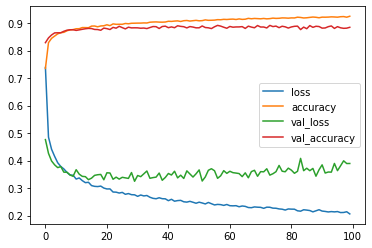

In [61]:
modelfinal_pd.plot()

In [62]:
model_final.evaluate(test_images, test_labels)

313/313 [==============================] - 0s 882us/step - loss: 0.3624 - accuracy: 0.8892


[0.3623940050601959, 0.88919997215271]

In [106]:
model_final.save("model_final.h5")